<a href="https://colab.research.google.com/github/OviRata/PMP-2024/blob/main/Partial/ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 3.3 MB/s eta 0:00:00


[['green' 'red' 'purple' 'brown' 'blue' 'brown' 'orange' 'yellow' 'brown'
  'yellow']
 ['blue' 'purple' 'red' 'yellow' 'purple' 'blue' 'brown' 'pink' 'blue'
  'pink']
 ['orange' 'green' 'brown' 'purple' 'orange' 'orange' 'cyan' 'brown'
  'red' 'yellow']
 ['blue' 'brown' 'cyan' 'red' 'purple' 'green' 'red' 'purple' 'blue'
  'yellow']
 ['blue' 'brown' 'brown' 'red' 'lime' 'yellow' 'pink' 'purple' 'red'
  'pink']
 ['brown' 'green' 'orange' 'lime' 'lime' 'blue' 'purple' 'orange' 'brown'
  'red']
 ['purple' 'orange' 'cyan' 'blue' 'pink' 'purple' 'pink' 'cyan' 'green'
  'orange']
 ['red' 'lime' 'yellow' 'cyan' 'brown' 'cyan' 'purple' 'cyan' 'lime'
  'cyan']
 ['pink' 'purple' 'blue' 'blue' 'orange' 'blue' 'blue' 'cyan' 'green'
  'lime']
 ['cyan' 'green' 'blue' 'pink' 'cyan' 'lime' 'red' 'yellow' 'yellow'
  'green']]
Cea mai probabila secventa de stari:  [70 70 71 72 82]


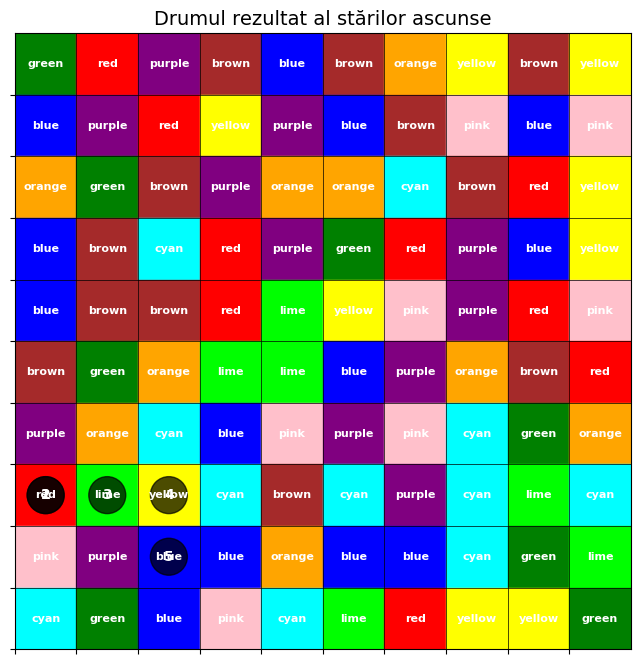

In [32]:

from hmmlearn import hmm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Dimensiunea gridului
dimensiune_grid = (10, 10)

# Lista de culori predefinite
culori = [
    "red", "blue", "green", "yellow",
    "purple", "orange", "pink", "cyan",
    "brown", "lime"
]

culoriDict = {};

for i in range(0, len(culori)):
    culoriDict[ culori[i] ] = i;


# Citirea gridului
df = pd.read_csv('grid_culori.csv', header=None)
grid_culori = df.to_numpy();
print(grid_culori);

# Generarea secvenței de culori observate
observatii = ['red', 'red', 'lime', 'yellow', 'blue' ];

# Mapare culori -> indecși
culoare_to_idx = {culoare: idx for idx, culoare in enumerate(culori)}
idx_to_culoare = {idx: culoare for culoare, idx in culoare_to_idx.items()}

# Transformăm secvența de observații în indecși
observatii_idx = [culoare_to_idx[c] for c in observatii]

# Definim stările ascunse ca fiind toate pozițiile din grid (100 de stări)
numar_stari = dimensiune_grid[0] * dimensiune_grid[1]
stari_ascunse = [(i, j) for i in range(dimensiune_grid[0]) for j in range(dimensiune_grid[1])]
stare_to_idx = {stare: idx for idx, stare in enumerate(stari_ascunse)}
idx_to_stare = {idx: stare for stare, idx in stare_to_idx.items()}

# Matrice de tranziție
transitions = np.zeros((numar_stari, numar_stari))
for i, j in stari_ascunse:
    vecini = [
        (i - 1, j), (i + 1, j), (i, j - 1), (i, j + 1)  # sus, jos, stânga, dreapta
    ]
    vecini_valizi = [stare_to_idx[(x, y)] for x, y in vecini if 0 <= x < 10 and 0 <= y < 10]

    prob = 0;

    if( (i, j-1) in vecini_valizi ):
        prob = (1-0.4)/(len(vecini_valizi))
    else:
        prob = (1)/(len(vecini_valizi)+1)

    current = i*10+j;
    for vecin in vecini_valizi:
        if((i,j-1) in vecini_valizi and vecin==stare_to_idx[(i, j-1)] ):
            transitions[current][vecin]=0.4;
        else:
            transitions[current][vecin] = prob;

    transitions[current][current] = prob;
    ######

# Matrice de emisie
emissions = np.zeros((numar_stari, len(culori)))
for stare in stari_ascunse:
  id = stare_to_idx[stare];
  i = stare[0];
  j = stare[1];
  emissions[ 10*i + j][ int(culoare_to_idx[ grid_culori[ i ][ j ] ]) ]=1.0;

######



# Modelul HMM
######


state_probability = np.full(numar_stari, 1/numar_stari);

model = hmm.CategoricalHMM(n_components=numar_stari);
model.startprob_ = state_probability
model.transmat_ = transitions
model.emissionprob_ = emissions



# Rulăm algoritmul Viterbi pentru secvența de observații
######

observations_sequence = np.array( observatii_idx ).reshape(-1, 1)
#algoritmul viterbi e folosit by default
hidden_states = model.predict(observations_sequence);
print("Cea mai probabila secventa de stari: ", hidden_states)

secventa_stari = hidden_states
# Convertim secvența de stări în poziții din grid
drum = [idx_to_stare[idx] for idx in secventa_stari]

# Vizualizăm drumul pe grid
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(dimensiune_grid[0]):
    for j in range(dimensiune_grid[1]):
        culoare = grid_culori[i, j]
        ax.add_patch(plt.Rectangle((j, dimensiune_grid[0] - i - 1), 1, 1, color=culoare))
        ax.text(j + 0.5, dimensiune_grid[0] - i - 0.5, culoare,
                color="white", ha="center", va="center", fontsize=8, fontweight="bold")

# Evidențiem drumul rezultat
for idx, (i, j) in enumerate(drum):
    ax.add_patch(plt.Circle((j + 0.5, dimensiune_grid[0] - i - 0.5), 0.3, color="black", alpha=0.7))
    ax.text(j + 0.5, dimensiune_grid[0] - i - 0.5, str(idx + 1),
            color="white", ha="center", va="center", fontsize=10, fontweight="bold")

# Setări axă
ax.set_xlim(0, dimensiune_grid[1])
ax.set_ylim(0, dimensiune_grid[0])
ax.set_xticks(range(dimensiune_grid[1]))
ax.set_yticks(range(dimensiune_grid[0]))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(visible=True, color="black", linewidth=0.5)
ax.set_aspect("equal")
plt.title("Drumul rezultat al stărilor ascunse", fontsize=14)
plt.show()

[['green' 'red' 'purple' 'brown' 'blue' 'brown' 'orange' 'yellow' 'brown'
  'yellow']
 ['blue' 'purple' 'red' 'yellow' 'purple' 'blue' 'brown' 'pink' 'blue'
  'pink']
 ['orange' 'green' 'brown' 'purple' 'orange' 'orange' 'cyan' 'brown'
  'red' 'yellow']
 ['blue' 'brown' 'cyan' 'red' 'purple' 'green' 'red' 'purple' 'blue'
  'yellow']
 ['blue' 'brown' 'brown' 'red' 'lime' 'yellow' 'pink' 'purple' 'red'
  'pink']
 ['brown' 'green' 'orange' 'lime' 'lime' 'blue' 'purple' 'orange' 'brown'
  'red']
 ['purple' 'orange' 'cyan' 'blue' 'pink' 'purple' 'pink' 'cyan' 'green'
  'orange']
 ['red' 'lime' 'yellow' 'cyan' 'brown' 'cyan' 'purple' 'cyan' 'lime'
  'cyan']
 ['pink' 'purple' 'blue' 'blue' 'orange' 'blue' 'blue' 'cyan' 'green'
  'lime']
 ['cyan' 'green' 'blue' 'pink' 'cyan' 'lime' 'red' 'yellow' 'yellow'
  'green']]
Cea mai probabila secventa de stari:  [43 43 44 45 55]


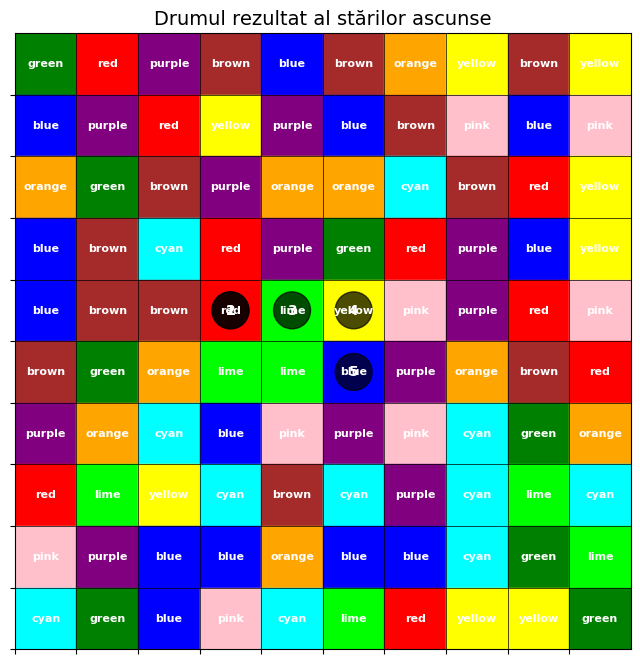

In [33]:
# daca eliminam probabilitatea de a merge la stanga:
from hmmlearn import hmm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Dimensiunea gridului
dimensiune_grid = (10, 10)

# Lista de culori predefinite
culori = [
    "red", "blue", "green", "yellow",
    "purple", "orange", "pink", "cyan",
    "brown", "lime"
]

culoriDict = {};

for i in range(0, len(culori)):
    culoriDict[ culori[i] ] = i;


# Citirea gridului
df = pd.read_csv('grid_culori.csv', header=None)
grid_culori = df.to_numpy();
print(grid_culori);

# Generarea secvenței de culori observate
observatii = ['red', 'red', 'lime', 'yellow', 'blue' ];

# Mapare culori -> indecși
culoare_to_idx = {culoare: idx for idx, culoare in enumerate(culori)}
idx_to_culoare = {idx: culoare for culoare, idx in culoare_to_idx.items()}

# Transformăm secvența de observații în indecși
observatii_idx = [culoare_to_idx[c] for c in observatii]

# Definim stările ascunse ca fiind toate pozițiile din grid (100 de stări)
numar_stari = dimensiune_grid[0] * dimensiune_grid[1]
stari_ascunse = [(i, j) for i in range(dimensiune_grid[0]) for j in range(dimensiune_grid[1])]
stare_to_idx = {stare: idx for idx, stare in enumerate(stari_ascunse)}
idx_to_stare = {idx: stare for stare, idx in stare_to_idx.items()}

# Matrice de tranziție
transitions = np.zeros((numar_stari, numar_stari))
for i, j in stari_ascunse:
    vecini = [
        (i - 1, j), (i + 1, j), (i, j + 1)  # sus, jos, stânga, dreapta
    ]
    vecini_valizi = [stare_to_idx[(x, y)] for x, y in vecini if 0 <= x < 10 and 0 <= y < 10]
    prob = (1)/(len(vecini_valizi)+1)

    current = i*10+j;
    for vecin in vecini_valizi:
        transitions[current][vecin]=prob;

    transitions[current][current] = prob;
    ######

# Matrice de emisie
emissions = np.zeros((numar_stari, len(culori)))
for stare in stari_ascunse:
  id = stare_to_idx[stare];
  i = stare[0];
  j = stare[1];
  emissions[ 10*i + j][ int(culoare_to_idx[ grid_culori[ i ][ j ] ]) ]=1.0;

######



# Modelul HMM
######


state_probability = np.full(numar_stari, 1/numar_stari);

model = hmm.CategoricalHMM(n_components=numar_stari);
model.startprob_ = state_probability
model.transmat_ = transitions
model.emissionprob_ = emissions



# Rulăm algoritmul Viterbi pentru secvența de observații
######

observations_sequence = np.array( observatii_idx ).reshape(-1, 1)
#algoritmul viterbi e folosit by default
hidden_states = model.predict(observations_sequence);
print("Cea mai probabila secventa de stari: ", hidden_states)

secventa_stari = hidden_states
# Convertim secvența de stări în poziții din grid
drum = [idx_to_stare[idx] for idx in secventa_stari]

# Vizualizăm drumul pe grid
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(dimensiune_grid[0]):
    for j in range(dimensiune_grid[1]):
        culoare = grid_culori[i, j]
        ax.add_patch(plt.Rectangle((j, dimensiune_grid[0] - i - 1), 1, 1, color=culoare))
        ax.text(j + 0.5, dimensiune_grid[0] - i - 0.5, culoare,
                color="white", ha="center", va="center", fontsize=8, fontweight="bold")

# Evidențiem drumul rezultat
for idx, (i, j) in enumerate(drum):
    ax.add_patch(plt.Circle((j + 0.5, dimensiune_grid[0] - i - 0.5), 0.3, color="black", alpha=0.7))
    ax.text(j + 0.5, dimensiune_grid[0] - i - 0.5, str(idx + 1),
            color="white", ha="center", va="center", fontsize=10, fontweight="bold")

# Setări axă
ax.set_xlim(0, dimensiune_grid[1])
ax.set_ylim(0, dimensiune_grid[0])
ax.set_xticks(range(dimensiune_grid[1]))
ax.set_yticks(range(dimensiune_grid[0]))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(visible=True, color="black", linewidth=0.5)
ax.set_aspect("equal")
plt.title("Drumul rezultat al stărilor ascunse", fontsize=14)
plt.show()

